In [ ]:
# === Updated Full Training Pipeline to Target ~85% Accuracy ===
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from collections import defaultdict

# === Load FFT Tensor ===
fft_tensor = np.load("/content/drive/MyDrive/DATASET CSV/fft_outputs/final_fft_tensor_4d.npy")
gesture_names = ["Pointer", "Power", "Open", "Tripod", "Lateral", "Rest"]

# === Convert to Dictionary ===
fft_data = defaultdict(list)
for i, gesture in enumerate(gesture_names):
    for trial in fft_tensor[i]:
        fft_data[gesture].append(trial)

# === Split ===
def split_fft_data(fft_data):
    train_data, test_data = {}, {}
    for gesture, trials in fft_data.items():
        train, test = train_test_split(trials, test_size=0.3, random_state=42)
        train_data[gesture] = train
        test_data[gesture] = test
    return train_data, test_data

train_fft_data, test_fft_data = split_fft_data(fft_data)

# === Dataset Class with Normalization + log1p ===
class FFTDataset(Dataset):
    def __init__(self, fft_data_dict):
        self.samples = []
        self.labels = []
        self.label_map = {gesture: idx for idx, gesture in enumerate(fft_data_dict.keys())}
        for gesture, trials in fft_data_dict.items():
            for trial in trials:
                trial = np.log1p(trial)
                trial = (trial - np.min(trial)) / (np.max(trial) - np.min(trial) + 1e-8)
                self.samples.append(torch.tensor(trial, dtype=torch.float32))
                self.labels.append(self.label_map[gesture])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx], self.labels[idx]

# === Dataloaders ===
def create_fft_dataloaders(train_data, test_data, batch_size=10):
    train_loader = DataLoader(FFTDataset(train_data), batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)
    test_loader = DataLoader(FFTDataset(test_data), batch_size=batch_size, shuffle=False, pin_memory=True)
    return train_loader, test_loader

batch_size = 10
train_loader, test_loader = create_fft_dataloaders(train_fft_data, test_fft_data, batch_size)

# === CNN Module (Deeper) ===
class CNN1D(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=5, stride=2),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Conv1d(32, 64, kernel_size=3, stride=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Conv1d(64, 128, kernel_size=3, stride=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(10),
        )

    def forward(self, x):
        return self.cnn(x)

# === Poisson Rate Encoder ===
class PoissonRateEncoder(nn.Module):
    def __init__(self, num_steps=10):
        super().__init__()
        self.num_steps = num_steps

    def forward(self, x):
        x = torch.clamp(x, 0, 1)
        b = x.size(0)
        # Add .contiguous() here
        f = x.contiguous().view(b, -1)
        return (torch.rand(b, self.num_steps, f.size(1), device=x.device) < f.unsqueeze(1)).float()

# === SNN (LSTM) ===
class SNN(nn.Module):
    def __init__(self, input_size, hidden_size=128, output_size=6):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

# === Full Pipeline ===
class FullPipeline(nn.Module):
    def __init__(self, cnn, encoder, snn):
        super().__init__()
        self.cnn = cnn
        self.encoder = encoder
        self.snn = snn

    def forward(self, x):
        b, c, f = x.shape
        x = x.view(b, 1, c * f)
        x = self.cnn(x)
        x = x.permute(0, 2, 1)
        spikes = self.encoder(x)
        return self.snn(spikes)

# === Utility: Get CNN Output Size ===
def get_flattened_cnn_output_size(cnn, input_width):
    dummy = torch.randn(1, 1, input_width)
    out = cnn(dummy)
    # Add .contiguous() here
    return out.contiguous().view(1, -1).shape[1]

# === Training ===
def train_model(model, train_loader, test_loader, epochs=100, device='cuda'):
    class_counts = [len(train_fft_data[k]) for k in gesture_names]
    class_weights = torch.tensor([1.0 / c for c in class_counts], dtype=torch.float32)
    class_weights /= class_weights.sum()
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.5)

    train_acc_history, test_acc_history = [], []

    for epoch in range(epochs):
        model.train()
        correct = total = 0
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

        train_acc = correct / total
        train_acc_history.append(train_acc)

        # Eval
        model.eval()
        correct = total = 0
        with torch.no_grad():
            for data, labels in test_loader:
                data, labels = data.to(device), labels.to(device)
                outputs = model(data)
                _, preds = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (preds == labels).sum().item()

        test_acc = correct / total
        test_acc_history.append(test_acc)
        scheduler.step(test_acc)

        print(f"Epoch {epoch+1}/{epochs} — Train Acc: {train_acc:.4f} — Test Acc: {test_acc:.4f}")

    return train_acc_history, test_acc_history

# === Plots ===
def plot_accuracy_curve(train_acc, test_acc):
    plt.figure(figsize=(8, 5))
    plt.plot(train_acc, label='Train Acc')
    plt.plot(test_acc, label='Test Acc')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Curve")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, test_loader, class_names, device='cuda'):
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            outputs = model(data)
            _, preds = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()

# === Build & Train ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn = CNN1D()
encoder = PoissonRateEncoder(num_steps=10)
snn_input_size = get_flattened_cnn_output_size(cnn, input_width=16 * 513)
snn = SNN(input_size=snn_input_size, hidden_size=128)

model = FullPipeline(cnn, encoder, snn).to(device)
try:
    model = torch.compile(model)
except:
    print("torch.compile not supported")

train_acc, test_acc = train_model(model, train_loader, test_loader, epochs=200, device=device)
plot_accuracy_curve(train_acc, test_acc)
plot_confusion_matrix(model, test_loader, gesture_names, device=device)

Epoch 1/200 — Train Acc: 0.4506 — Test Acc: 0.5257
Epoch 2/200 — Train Acc: 0.5009 — Test Acc: 0.5229
Epoch 3/200 — Train Acc: 0.5315 — Test Acc: 0.5451
Epoch 4/200 — Train Acc: 0.5482 — Test Acc: 0.5556
Epoch 5/200 — Train Acc: 0.5577 — Test Acc: 0.5854
Epoch 6/200 — Train Acc: 0.5905 — Test Acc: 0.5979
Epoch 7/200 — Train Acc: 0.6092 — Test Acc: 0.5944
Epoch 8/200 — Train Acc: 0.6253 — Test Acc: 0.6049
Epoch 9/200 — Train Acc: 0.6393 — Test Acc: 0.6215
Epoch 10/200 — Train Acc: 0.6509 — Test Acc: 0.6181
Epoch 11/200 — Train Acc: 0.6604 — Test Acc: 0.6319
Epoch 12/200 — Train Acc: 0.6676 — Test Acc: 0.6736
Epoch 13/200 — Train Acc: 0.6789 — Test Acc: 0.6549
Epoch 14/200 — Train Acc: 0.6792 — Test Acc: 0.6514
Epoch 15/200 — Train Acc: 0.6824 — Test Acc: 0.6618
Epoch 16/200 — Train Acc: 0.6911 — Test Acc: 0.6528
Epoch 17/200 — Train Acc: 0.7027 — Test Acc: 0.6924
Epoch 18/200 — Train Acc: 0.7033 — Test Acc: 0.6757
Epoch 19/200 — Train Acc: 0.7018 — Test Acc: 0.6972
Epoch 20/200 — Train 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-2968542489.py", line 222, in <cell line: 0>
    train_acc, test_acc = train_model(model, train_loader, test_loader, epochs=200, device=device)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2968542489.py", line 147, in train_model
    outputs = model(data)
              ^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py", line 1739, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py", line 1750, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/

TypeError: object of type 'NoneType' has no len()

Epoch 1/100 — Train Acc: 0.4866 — Test Acc: 0.5354
Epoch 2/100 — Train Acc: 0.5935 — Test Acc: 0.6139
Epoch 3/100 — Train Acc: 0.6182 — Test Acc: 0.6514
Epoch 4/100 — Train Acc: 0.6381 — Test Acc: 0.6521
Epoch 5/100 — Train Acc: 0.6616 — Test Acc: 0.6694
Epoch 6/100 — Train Acc: 0.6664 — Test Acc: 0.6403
Epoch 7/100 — Train Acc: 0.7074 — Test Acc: 0.6972
Epoch 8/100 — Train Acc: 0.7077 — Test Acc: 0.7271
Epoch 9/100 — Train Acc: 0.7408 — Test Acc: 0.6646
Epoch 10/100 — Train Acc: 0.7432 — Test Acc: 0.7549
Epoch 11/100 — Train Acc: 0.7530 — Test Acc: 0.7507
Epoch 12/100 — Train Acc: 0.7482 — Test Acc: 0.7382
Epoch 13/100 — Train Acc: 0.7655 — Test Acc: 0.7285
Epoch 14/100 — Train Acc: 0.7676 — Test Acc: 0.7500
Epoch 15/100 — Train Acc: 0.7676 — Test Acc: 0.7556
Epoch 16/100 — Train Acc: 0.7795 — Test Acc: 0.7590
Epoch 17/100 — Train Acc: 0.7979 — Test Acc: 0.7597
Epoch 18/100 — Train Acc: 0.7973 — Test Acc: 0.7826
Epoch 19/100 — Train Acc: 0.7899 — Test Acc: 0.7729
Epoch 20/100 — Train 

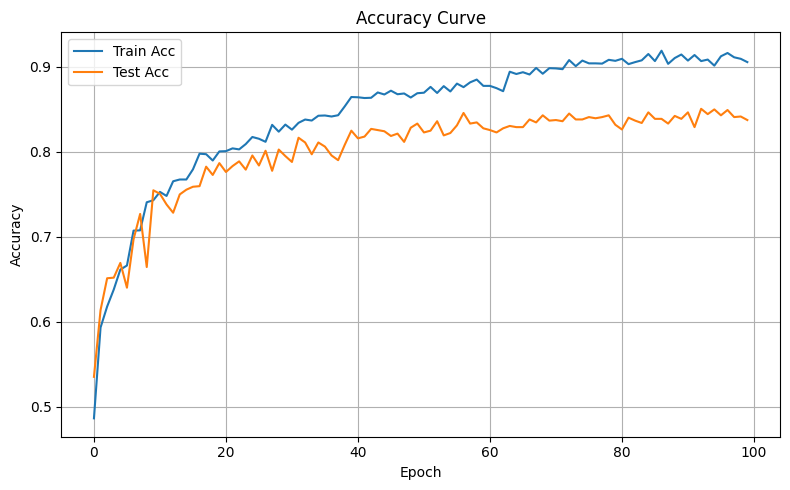

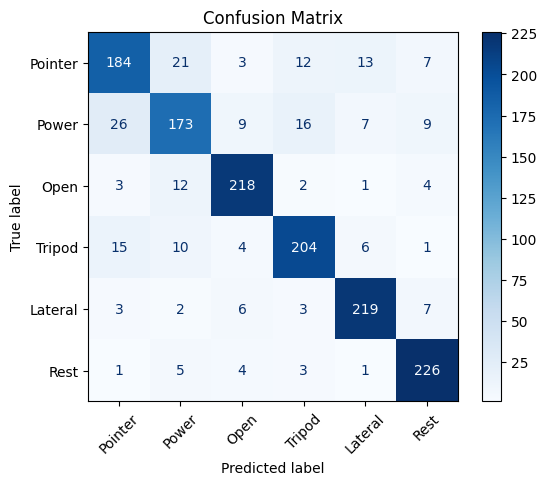

In [ ]:
# === Updated Full Pipeline with CNN2D + BiLSTM for Higher Accuracy ===
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from collections import defaultdict

# === Load FFT Tensor ===
fft_tensor = np.load("/content/drive/MyDrive/DATASET CSV/fft_outputs/final_fft_tensor_4d.npy")
gesture_names = ["Pointer", "Power", "Open", "Tripod", "Lateral", "Rest"]

# === Convert to Dictionary ===
fft_data = defaultdict(list)
for i, gesture in enumerate(gesture_names):
    for trial in fft_tensor[i]:
        fft_data[gesture].append(trial)

# === Split ===
def split_fft_data(fft_data):
    train_data, test_data = {}, {}
    for gesture, trials in fft_data.items():
        train, test = train_test_split(trials, test_size=0.3, random_state=42)
        train_data[gesture] = train
        test_data[gesture] = test
    return train_data, test_data

train_fft_data, test_fft_data = split_fft_data(fft_data)

# === Dataset Class with log1p + normalization ===
class FFTDataset(Dataset):
    def __init__(self, fft_data_dict):
        self.samples = []
        self.labels = []
        self.label_map = {gesture: idx for idx, gesture in enumerate(fft_data_dict.keys())}
        for gesture, trials in fft_data_dict.items():
            for trial in trials:
                trial = np.log1p(trial)
                trial = (trial - np.min(trial)) / (np.max(trial) - np.min(trial) + 1e-8)
                self.samples.append(torch.tensor(trial, dtype=torch.float32))
                self.labels.append(self.label_map[gesture])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x = self.samples[idx].unsqueeze(0)  # shape (1, 16, 513)
        y = self.labels[idx]
        return x, y

# === Dataloaders ===
def create_fft_dataloaders(train_data, test_data, batch_size=10):
    train_loader = DataLoader(FFTDataset(train_data), batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)
    test_loader = DataLoader(FFTDataset(test_data), batch_size=batch_size, shuffle=False, pin_memory=True)
    return train_loader, test_loader

batch_size = 10
train_loader, test_loader = create_fft_dataloaders(train_fft_data, test_fft_data, batch_size)

# === CNN2D ===
class CNN2D(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.AdaptiveAvgPool2d((4, 4))  # output: (B, 128, 4, 4)
        )

    def forward(self, x):
        return self.cnn(x)

# === Poisson Encoder ===
class PoissonRateEncoder(nn.Module):
    def __init__(self, num_steps=10):
        super().__init__()
        self.num_steps = num_steps

    def forward(self, x):  # x: (B, F)
        x = torch.clamp(x, 0, 1)
        B, F = x.shape
        spikes = (torch.rand(B, self.num_steps, F, device=x.device) < x.unsqueeze(1)).float()
        return spikes  # (B, T, F)

# === BiLSTM SNN ===
class SNN(nn.Module):
    def __init__(self, input_size, hidden_size=128, output_size=6):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

# === Full Pipeline ===
class FullPipeline(nn.Module):
    def __init__(self, cnn, encoder, snn):
        super().__init__()
        self.cnn = cnn
        self.encoder = encoder
        self.snn = snn

    def forward(self, x):
        x = self.cnn(x)  # (B, 128, 4, 4)
        x = x.view(x.size(0), -1)  # (B, 2048)
        spikes = self.encoder(x)  # (B, T, F=2048)
        return self.snn(spikes)

# === Training ===
def train_model(model, train_loader, test_loader, epochs=50, device='cuda'):
    class_counts = [len(train_fft_data[k]) for k in gesture_names]
    class_weights = torch.tensor([1.0 / c for c in class_counts], dtype=torch.float32)
    class_weights /= class_weights.sum()
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.5)

    train_acc_history, test_acc_history = [], []

    for epoch in range(epochs):
        model.train()
        correct = total = 0
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
        train_acc = correct / total
        train_acc_history.append(train_acc)

        model.eval()
        correct = total = 0
        with torch.no_grad():
            for data, labels in test_loader:
                data, labels = data.to(device), labels.to(device)
                outputs = model(data)
                _, preds = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (preds == labels).sum().item()
        test_acc = correct / total
        test_acc_history.append(test_acc)
        scheduler.step(test_acc)
        print(f"Epoch {epoch+1}/{epochs} — Train Acc: {train_acc:.4f} — Test Acc: {test_acc:.4f}")

    return train_acc_history, test_acc_history

# === Plot Functions ===
def plot_accuracy_curve(train_acc, test_acc):
    plt.figure(figsize=(8, 5))
    plt.plot(train_acc, label='Train Acc')
    plt.plot(test_acc, label='Test Acc')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Curve")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, test_loader, class_names, device='cuda'):
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            outputs = model(data)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()

# === Run Training ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn = CNN2D()
encoder = PoissonRateEncoder(num_steps=10)
snn_input_size = 128 * 4 * 4
snn = SNN(input_size=snn_input_size, hidden_size=128)
model = FullPipeline(cnn, encoder, snn).to(device)

try:
    model = torch.compile(model)
except:
    print("torch.compile not supported")

train_acc, test_acc = train_model(model, train_loader, test_loader, epochs=100, device=device)
plot_accuracy_curve(train_acc, test_acc)
plot_confusion_matrix(model, test_loader, gesture_names, device=device)